#Part II: Using Transfer Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50

##Data preparation:

In [2]:
(X_train, Y_train), (X_test, Y_test) = datasets.fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

4431872/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


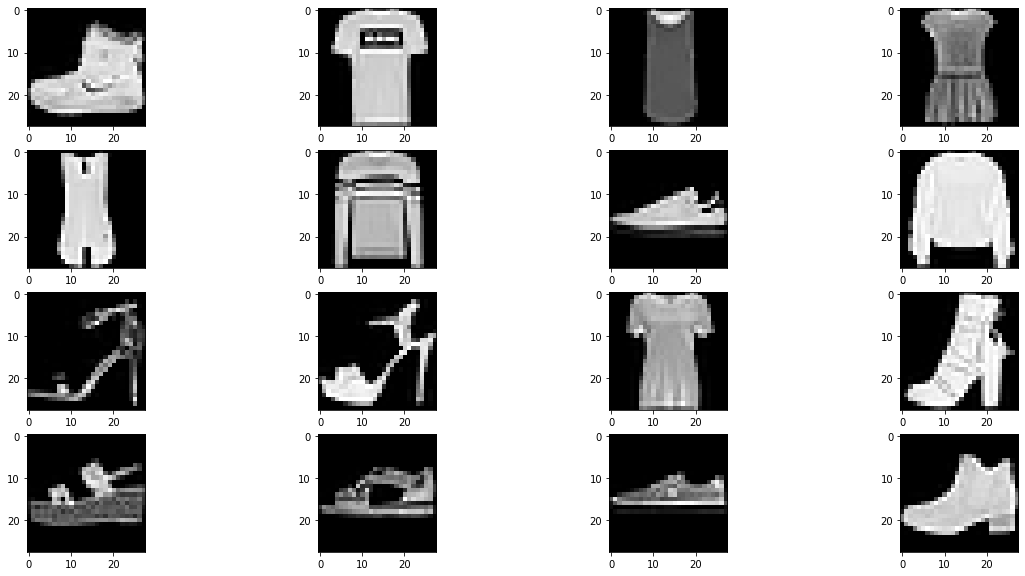

In [3]:
i, j = 0, 0
fig, ax = plt.subplots(4, 4, figsize=(20, 10))
for k in range(16):
    ax[i, j].imshow(X_train[k], cmap = "gray")
    j = j + 1
    if j == 4:
      i = i + 1
      j = 0

In [4]:
X_train, X_test = X_train.reshape((X_train.shape[0], 28, 28, 1)), X_test.reshape((X_test.shape[0], 28, 28, 1))

X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32')  / 255.0

Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)

<div dir = 'rtl'>
برای آماده سازی داده ها، تصاویر را هم اندازه کرده ایم.

بعد از آن مقدار سطح روشنایی پیکسل هر تصویر را اسکیل بین 0 تا 1 کرده ایم تا دقت مدل درست تنظیم شود و در آخر نیز ویژگی هدف را به صورت بردار وان هات تعریف مرده ایم تا یک دسته بندی مناسب بتوانیم انجام دهیم.
<div>

In [5]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5)
print(f'test size: X = {X_test.shape}, y = {Y_test.shape}')
print(f'valudation size: X = {X_val.shape}, y = {Y_val.shape}')

test size: X = (5000, 28, 28, 1), y = (5000, 10)
valudation size: X = (5000, 28, 28, 1), y = (5000, 10)


In [6]:
X_train, X_val, X_test = np.concatenate([X_train] * 3, axis = 3), np.concatenate([X_val] * 3, axis = 3), np.concatenate([X_test] * 3, axis = 3)

X_train = np.array([np.array(cv2.resize(image, dsize = (32, 32), interpolation = cv2.INTER_CUBIC), dtype = np.float32) for image in X_train])
X_val = np.array([np.array(cv2.resize(image, dsize = (32, 32), interpolation = cv2.INTER_CUBIC), dtype = np.float32) for image in X_val])
X_test = np.array([np.array(cv2.resize(image, dsize = (32, 32), interpolation = cv2.INTER_CUBIC), dtype = np.float32) for image in X_test])

<div dir = 'rtl'>
برای اینکه از شبکه از قبل آموزش داده شده مورد نظر استفاده کنیم باید تصاویر دارای سه کانال سطح روشنایی باشند به همین دلیل داده های آموزشی را به صورت rgb در آوردیم با این تفاوت که سطح روشنایی هر سه کانال یکی بوده و تصاویر خاکستری مانده اند.

همچنین مدل مورد نطر نیاز به تصاویر با اندازه 32 * 32 دارد که با استفاده از کتاب خانه openCV تصاویر تغییر اندازه پیدا کردند.
<div>

##Scenario 1:

In [15]:
TL_ResNet = ResNet50(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)

top = TL_ResNet.output
top = layers.GlobalAveragePooling2D()(top)
top = layers.Dense(128 , activation = 'relu')(top)
top = tf.keras.layers.Dropout(0.2)(top)
top = layers.Dense(64, activation = 'relu')(top)
top = tf.keras.layers.Dropout(0.5)(top)
top = layers.Dense(10 , activation = 'softmax')(top)
TL_model = models.Model(inputs = TL_ResNet.inputs , outputs = top)
TL_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

<div dir = 'rtl'>
براساس گزارش داده شده از این مدل تعداد بسیار زیادی پارامتر برای یادگیری وجود دارد و این مدل پیچیده تری هست و انتظار می رود دقت یادگیری بالایی داشته باشد.

در مدل دیگر این تعداد کمتر است و تفاوت بین این دو سناریو قابل مشاهده است.
<div>

In [16]:
TL_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])
es = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
TL_model_report = TL_model.fit(X_train, Y_train, epochs = 10, batch_size = 500, validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/10
120/120 - 26s - loss: 0.6102 - accuracy: 0.8117 - val_loss: 2.8388 - val_accuracy: 0.1030 - 26s/epoch - 219ms/step
Epoch 2/10
120/120 - 21s - loss: 0.3134 - accuracy: 0.9012 - val_loss: 3.3354 - val_accuracy: 0.1030 - 21s/epoch - 172ms/step
Epoch 3/10
120/120 - 21s - loss: 0.2519 - accuracy: 0.9186 - val_loss: 4.0596 - val_accuracy: 0.1036 - 21s/epoch - 174ms/step
Epoch 4/10
120/120 - 21s - loss: 0.2253 - accuracy: 0.9272 - val_loss: 2.4131 - val_accuracy: 0.1896 - 21s/epoch - 171ms/step
Epoch 5/10
120/120 - 21s - loss: 0.1941 - accuracy: 0.9360 - val_loss: 1.5732 - val_accuracy: 0.6238 - 21s/epoch - 172ms/step
Epoch 6/10
120/120 - 21s - loss: 0.1806 - accuracy: 0.9393 - val_loss: 1.3789 - val_accuracy: 0.6860 - 21s/epoch - 171ms/step
Epoch 7/10
120/120 - 21s - loss: 0.1640 - accuracy: 0.9449 - val_loss: 0.6986 - val_accuracy: 0.8286 - 21s/epoch - 172ms/step
Epoch 8/10
120/120 - 21s - loss: 0.1552 - accuracy: 0.9489 - val_loss: 0.8716 - val_accuracy: 0.8256 - 21s/epoch - 173

157/157 - 3s - loss: 0.4847 - accuracy: 0.9174 - 3s/epoch - 18ms/step


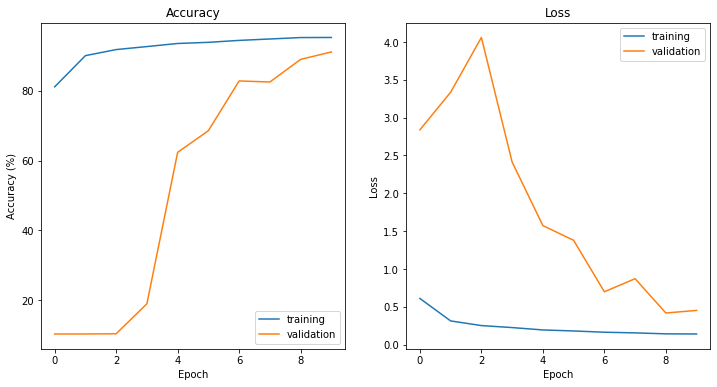

In [17]:
TL_model.evaluate(X_test, Y_test, verbose = 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.set_title('Accuracy')
ax1.plot(np.array(TL_model_report.history['accuracy']) * 100, label = 'training')
ax1.plot(np.array(TL_model_report.history['val_accuracy']) * 100, label = 'validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()   
ax2.set_title('Loss')
ax2.plot(np.array(TL_model_report.history['loss']), label='training')
ax2.plot(np.array(TL_model_report.history['val_loss']), label = 'validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

<div dir = 'rtl'>
مشاهده می شود زمان آموزش بسیار زیاد است اما یادگیری بهتری دارد زیرا شبکه کانوولوشنی نیز در حال یادگیری می باشد.

همچنین طراحی مدل باعث بهبود آن شده است و نتیجه بهتری حاصل شده است.

براساس نمودار مقدار loss کمتر و نزدیکتر می شود و دقت داده های validation به دقت داده های آموزشی نزدیک تر می شود بنابراین نتیجه ای که انتظار می رفت به دست آمد.
<div>

##Scenario 2:

In [18]:
TL_ResNet = ResNet50(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
for layer in TL_ResNet.layers:
    layer.trainable = False

top = TL_ResNet.output
top = layers.GlobalAveragePooling2D()(top)
top = layers.Dense(128 , activation = 'relu')(top)
top = tf.keras.layers.Dropout(0.2)(top)
top = layers.Dense(64, activation = 'relu')(top)
top = tf.keras.layers.Dropout(0.5)(top)
top = layers.Dense(32, activation = 'relu')(top)
top = layers.Dense(10 , activation = 'softmax')(top)
TL_model = models.Model(inputs = TL_ResNet.inputs , outputs = top)
TL_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

<div dir = 'rtl'>
تعداد پارامتر های یادگیری کمتر شده است بنابراین انتظار می رود دقت پایین تر و سرعت بیشتر آموزش را ببینیم.
<div>

In [20]:
TL_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])
es = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
TL_model_report = TL_model.fit(X_train, Y_train, epochs = 10, batch_size = 500, validation_data = (X_val, Y_val), callbacks = [es], verbose = 2)

Epoch 1/10
120/120 - 9s - loss: 1.5931 - accuracy: 0.3808 - val_loss: 1.0295 - val_accuracy: 0.6164 - 9s/epoch - 76ms/step
Epoch 2/10
120/120 - 6s - loss: 1.0615 - accuracy: 0.5920 - val_loss: 0.8250 - val_accuracy: 0.6780 - 6s/epoch - 46ms/step
Epoch 3/10
120/120 - 6s - loss: 0.9155 - accuracy: 0.6522 - val_loss: 0.7504 - val_accuracy: 0.7188 - 6s/epoch - 48ms/step
Epoch 4/10
120/120 - 6s - loss: 0.8497 - accuracy: 0.6805 - val_loss: 0.7027 - val_accuracy: 0.7366 - 6s/epoch - 46ms/step
Epoch 5/10
120/120 - 6s - loss: 0.8021 - accuracy: 0.7007 - val_loss: 0.6882 - val_accuracy: 0.7396 - 6s/epoch - 49ms/step
Epoch 6/10
120/120 - 6s - loss: 0.7843 - accuracy: 0.7060 - val_loss: 0.6979 - val_accuracy: 0.7300 - 6s/epoch - 46ms/step
Epoch 7/10
120/120 - 6s - loss: 0.7594 - accuracy: 0.7148 - val_loss: 0.6920 - val_accuracy: 0.7402 - 6s/epoch - 47ms/step
Epoch 8/10
120/120 - 6s - loss: 0.7321 - accuracy: 0.7242 - val_loss: 0.6545 - val_accuracy: 0.7448 - 6s/epoch - 48ms/step
Epoch 9/10
120/1

157/157 - 3s - loss: 0.6236 - accuracy: 0.7564 - 3s/epoch - 18ms/step


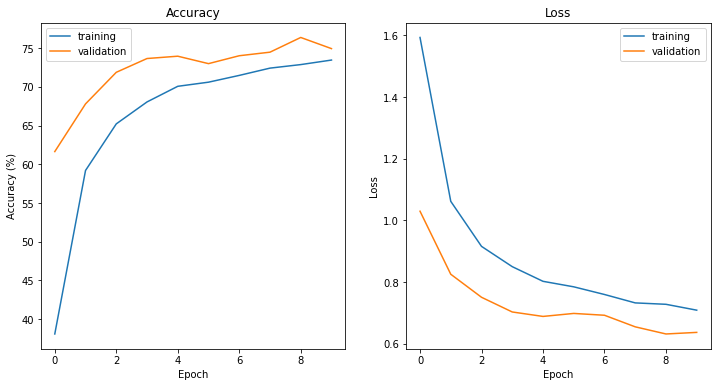

In [21]:
TL_model.evaluate(X_test, Y_test, verbose = 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.set_title('Accuracy')
ax1.plot(np.array(TL_model_report.history['accuracy']) * 100, label = 'training')
ax1.plot(np.array(TL_model_report.history['val_accuracy']) * 100, label = 'validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.legend()   
ax2.set_title('Loss')
ax2.plot(np.array(TL_model_report.history['loss']), label='training')
ax2.plot(np.array(TL_model_report.history['val_loss']), label = 'validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

<div dir = 'rtl'>
سرعت آموزش بالا رفته است اما دقت نسبت به سناریو اول پایین تر آماده است. مدل نیز متعادل تر رفتار کرده است و می توان گفت مدل آموزش دیده بر مدل ما غلبه کرده و بهبود بخشیده است. به نظر می آید این سناریو بیشتر برای استخراج ویژگی استفاده شود و زمانی که داده ها ترتیب خود را حفظ کرده اند مفید باشد و سناریو اول برای این مسئله مناسب تر باشد.

مطابق نمودار مشاهده می شود مدل مناسب انتخاب شده است و آموزش خوبی داشته است و دقت مورد نظر را نیز دارد.
<div>